In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **1. Data preparation**

In [23]:
df_train = pd.read_csv('../input/dapprojekt22/train.csv')
df_test = pd.read_csv('../input/dapprojekt22/test.csv')

df_merged = pd.concat((df_train, df_test), axis=0).sort_values('GAME_ID_HOME')

In [24]:
df_merged.head()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT,id
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,14,0.452,0.424,0.197,0.198,MIA,CHI,0.0,1.489674,NaN
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,26,0.375,0.591,0.198,0.196,LAL,LAC,0.0,5.361710,NaN
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,27,0.462,0.435,0.200,0.200,CLE,BKN,0.0,2.357026,NaN
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,21,0.426,0.525,0.200,0.195,PHI,MIA,0.0,5.980445,NaN
4,30,24,0.714,0.558,21.5,18.1,1.58,1.33,1,0,...,26,0.485,0.520,0.200,0.200,TOR,BOS,0.0,1.283159,NaN


In [25]:
df_merged.tail()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT,id
1225,19,21,0.633,0.538,15.9,17.3,0.95,2.10,7,4,...,15,0.441,0.417,0.196,0.200,UTA,SAS,NaN,NaN,1225.0
1226,16,24,0.410,0.615,13.0,18.9,1.07,1.41,5,2,...,20,0.477,0.500,0.200,0.198,LAC,SAC,NaN,NaN,1226.0
1227,27,29,0.675,0.674,21.6,22.5,2.45,4.83,6,1,...,18,0.537,0.383,0.198,0.200,GSW,LAL,NaN,NaN,1227.0
1228,23,26,0.561,0.634,16.4,17.7,1.28,1.24,8,2,...,19,0.381,0.404,0.200,0.198,POR,NOP,NaN,NaN,1228.0
1229,20,22,0.500,0.537,15.4,16.0,1.82,0.88,2,3,...,19,0.436,0.432,0.200,0.197,CLE,BOS,NaN,NaN,1229.0


In [26]:
df_merged['PTS'] = df_merged['PTS_HOME'] + df_merged['PTS_AWAY']

df_merged[['PTS']].head()

,PTS
0,184
1,202
2,219
3,192
4,224


In [27]:
df_pts = df_merged[['PTS']][-600:]
df_rtg = df_merged[['OFF_RATING_HOME', 'OFF_RATING_AWAY', 'DEF_RATING_HOME', 'DEF_RATING_AWAY', 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY', 'NEXT_HOME', 'NEXT_AWAY']][-600:]

df_pts.shape

(600, 1)

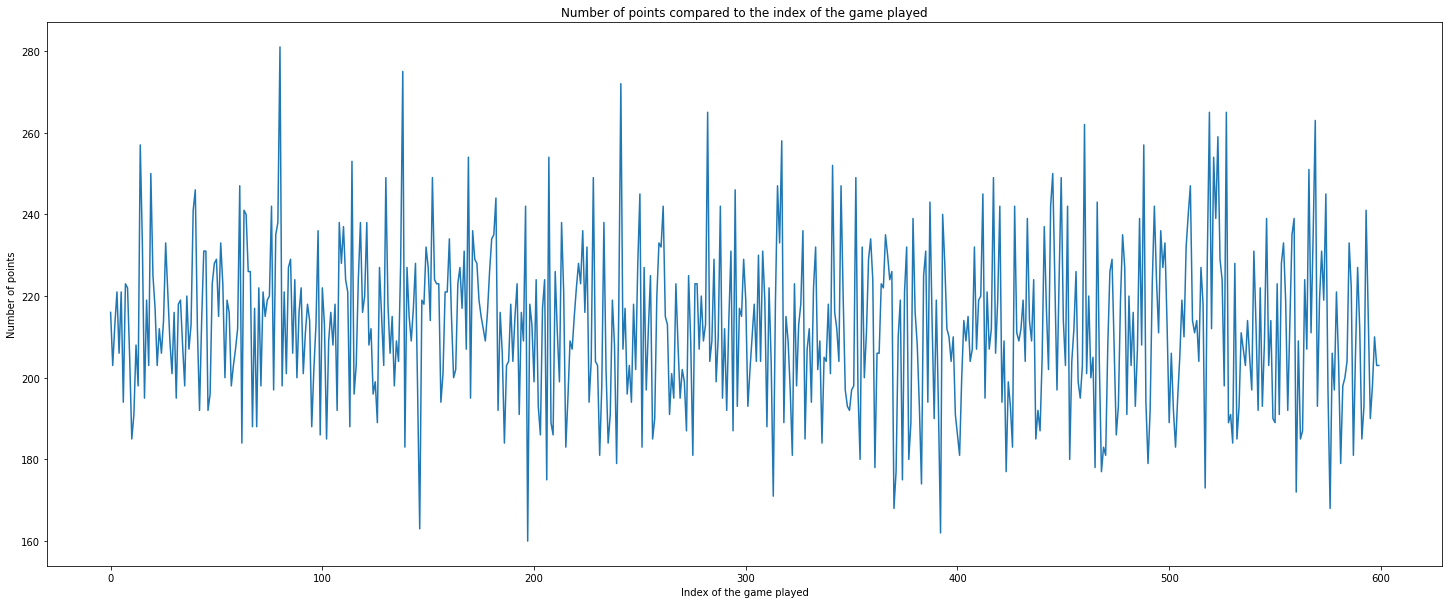

In [28]:
plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts.shape[0])), df_pts)
plt.xlabel('Index of the game played')
plt.ylabel('Number of points')
plt.title('Number of points compared to the index of the game played')
plt.show()

The time series looks random and there doesn't seem to be a pattern. There are no trends or periodicity.

## **2. Exponential smoothing**

In [29]:
df_pts_train = df_pts[:-100]
df_pts_test = df_pts[-100:]

print(df_pts_train.shape)
print(df_pts_test.shape)

(500, 1)
(100, 1)


RMSE: 20.805073004263168
 MAE: 16.4358319737556


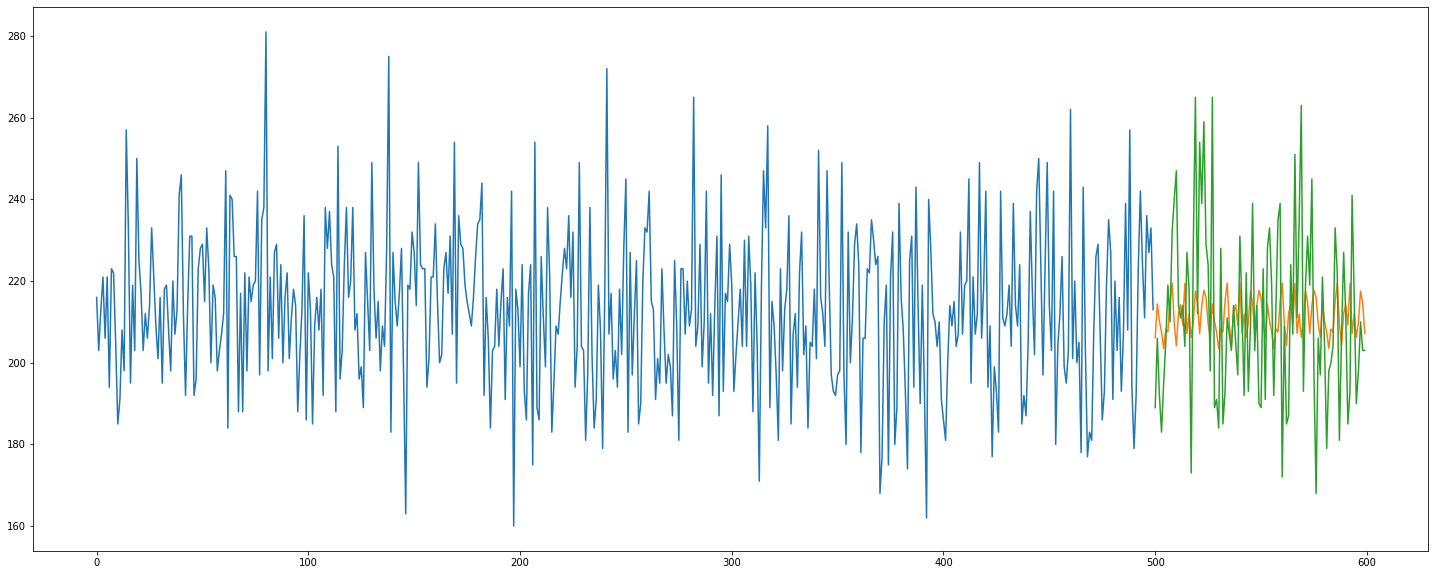

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

exp_smooth = ExponentialSmoothing(
    df_pts_train['PTS'],  
    seasonal_periods=26,
    trend='add',
    seasonal='add', 
    use_boxcox=True,
    damped=True,
    initialization_method='estimated'
).fit()
forecasted = exp_smooth.forecast(steps=df_pts_test.shape[0])

rmse = mean_squared_error(forecasted, df_pts_test, squared=False)
mae = mean_absolute_error(forecasted, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), forecasted)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|seasonal_periods|trend|seasonal|use_boxcox|damped|initialization_method|smoothing_level|smoothing_trend|smoothing_seasonal|RMSE  |MAE   |
|:---            |:--- |:---    |:---      |      |:---                 |:---           |:---           |:---              |:---  |:---  |
|21              |add  |add     |True      |False |                     |1.25           |0.01           |0.45              |33.763|25.725|
|20              |add  |add     |True      |False |                     |1.25           |0.01           |0.45              |40.248|33.375|
|19              |add  |add     |True      |False |                     |1.25           |0.01           |0.45              |29.938|24.159|
|19              |add  |add     |True      |False |                     |1              |0.01           |0.45              |28.796|23.294|
|20              |add  |add     |True      |False |estimated            |               |               |                  |21.957|17.607|
|21              |add  |add     |True      |False |estimated            |               |               |                  |21.826|17.273|
|22              |add  |add     |True      |False |estimated            |               |               |                  |21.653|17.409|
|23              |add  |add     |True      |False |estimated            |               |               |                  |21.541|17.271|
|26              |add  |add     |True      |False |estimated            |               |               |                  |20.973|**16.296**|
|26              |add  |add     |True      |True  |estimated            |               |               |                  |**20.805**|16.436|

The predictions of the basic model aren't useful because it's always the same prediction for every timestep. I managed to improve the performance of the algorithm by changing the hyperparameters. The results are shown in the table.

## **3. ARIMA**

RMSE: 21.36564233829178
 MAE: 17.278239412685103


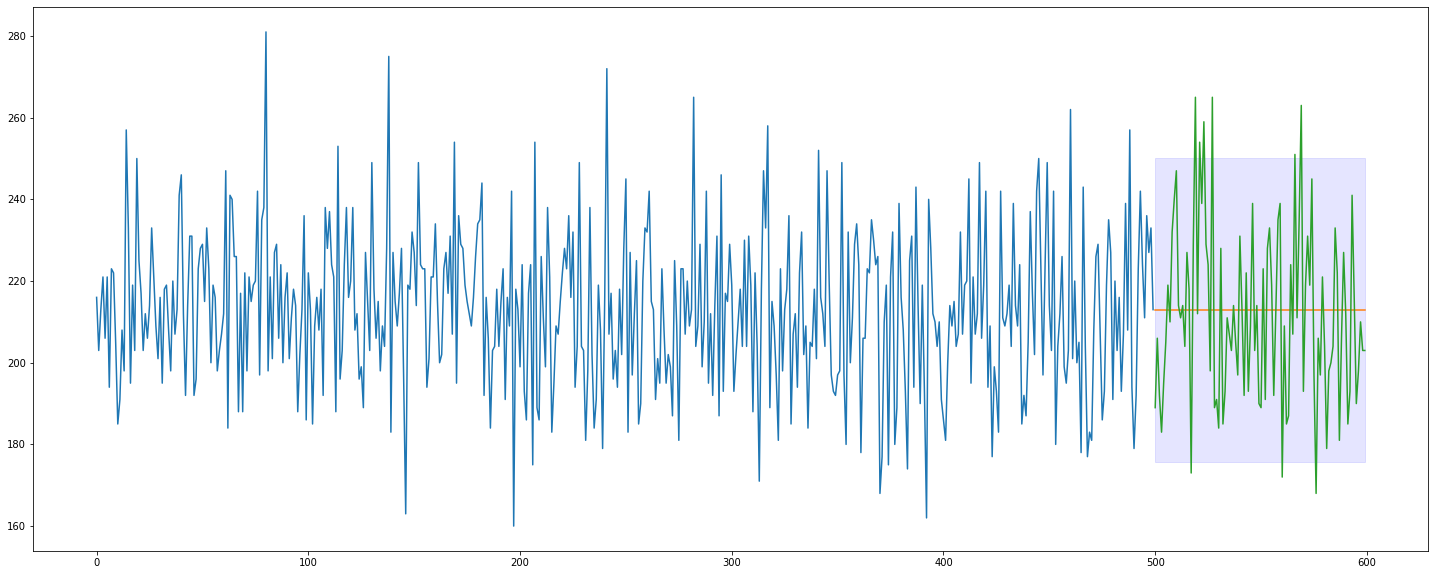

In [31]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(25, 10))
arima = ARIMA(
    df_pts_train['PTS']
).fit()
forecasted = arima.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

The width of the confidence intervals suggest that the predictions aren't very certain because of the width of the interval. The problem with the predictions remains the same as with the last algorithm. The predictions of the basic model aren't useful because it's always the same prediction for every timestep.

RMSE: 21.25934785285611
 MAE: 17.283498917023387


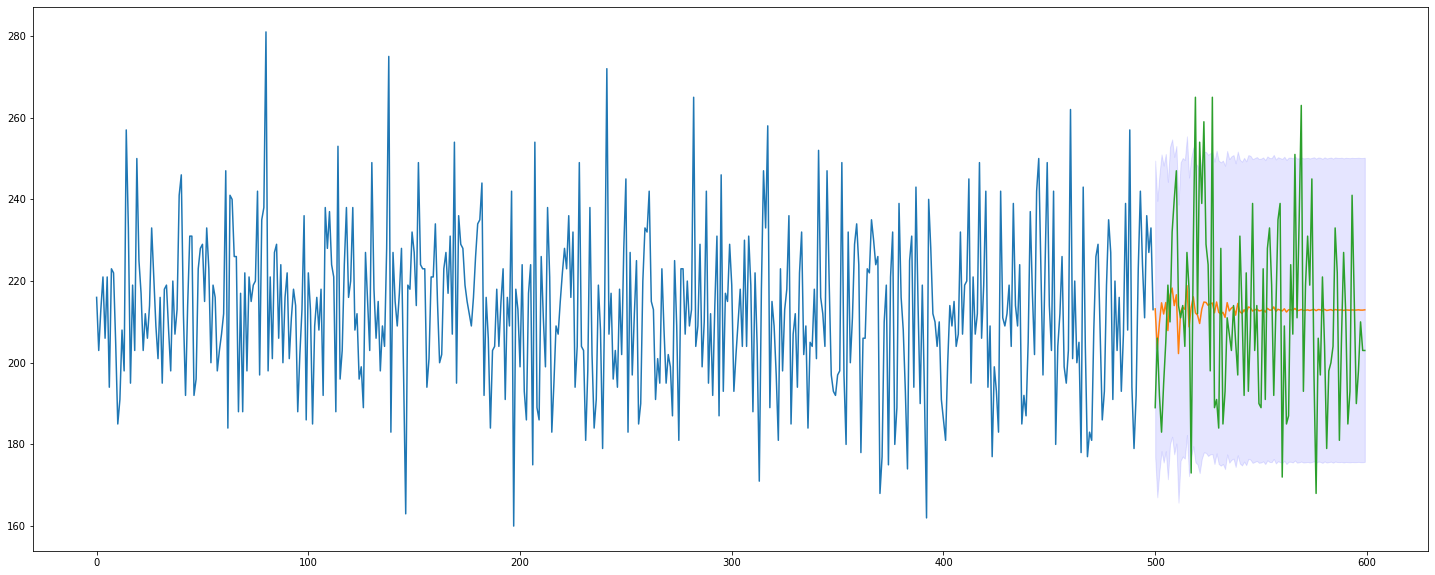

In [32]:
arima2 = ARIMA(
    df_pts_train['PTS'],
    order=(30,0,0)
).fit()
forecasted = arima2.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|exog|order     |seasonal_order|trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---      |:---          |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(0, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.366|17.278|
|None|(1, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.366|17.278|
|None|(2, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.356|17.269|
|None|(3, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.359|17.273|
|None|(5, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.315|17.219|
|None|(8, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.298|**17.199**|
|None|(10, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.300|17.213|
|None|(15, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.300|17.208|
|None|(20, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.290|17.212|
|None|(25, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.392|17.393|
|None|(30, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |**21.259**|17.283|
|None|(40, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.468|17.487|
|None|(50, 0, 0)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.487|17.507|

The $p$ parameter barely affects the error. The appearance of the prediction curve becomes more nonlinear in the first few timesteps by increasing the value. 

RMSE: 21.284815678223023
 MAE: 17.280282945017376


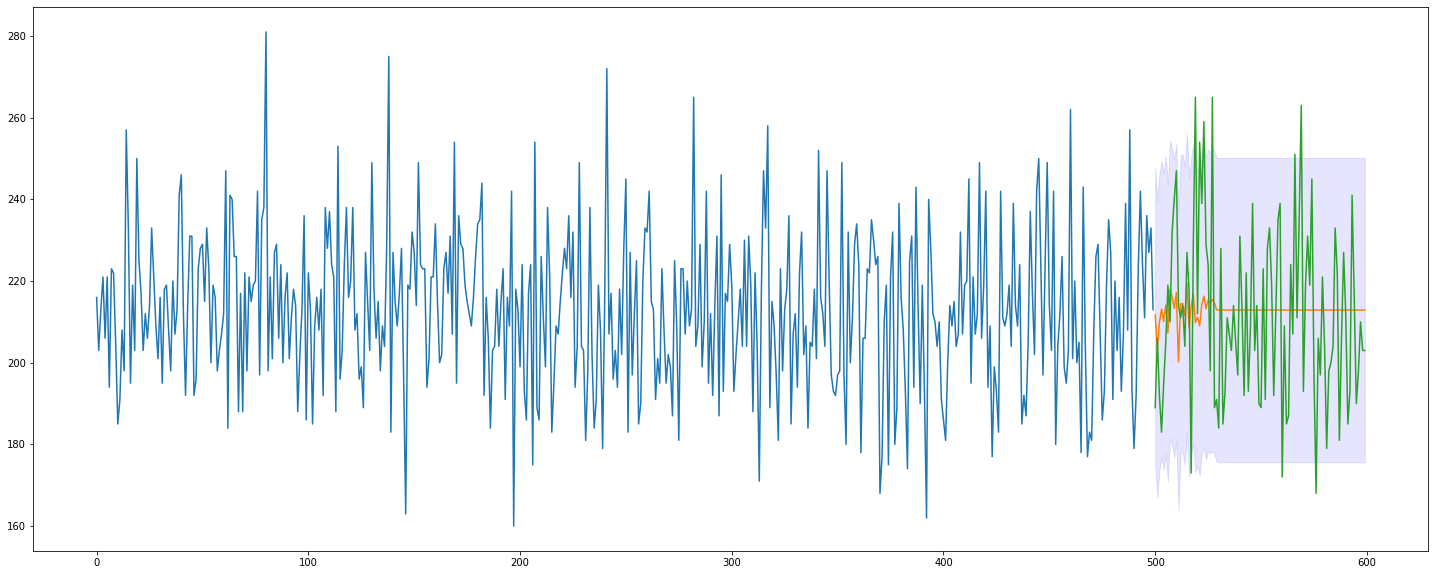

In [33]:
arima2 = ARIMA(
    df_pts_train['PTS'],
    order=(0,0,30)
).fit()
forecasted = arima2.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|exog|order     |seasonal_order|trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---      |:---          |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(0, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.366|17.278|
|None|(0, 0, 1) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.365|17.278|
|None|(0, 0, 2) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.354|17.267|
|None|(0, 0, 3) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.355|17.269|
|None|(0, 0, 4) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.305|17.209|
|None|(0, 0, 5) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.305|**17.208**|
|None|(0, 0, 8) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.308|17.208|
|None|(0, 0, 10)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.314|17.228|
|None|(0, 0, 15)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.326|17.267|
|None|(0, 0, 20)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.329|17.292|
|None|(0, 0, 25)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.474|17.463|
|None|(0, 0, 30)|(0, 0, 0, 0)  |None |True                |True                 |False            |**21.284**|17.280|
|None|(0, 0, 40)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.454|17.421|
|None|(0, 0, 50)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.628|17.648|

This parameter also barely affects the error. It also affects the nonlinearity of the prediction the same way as does parameter $p$. 

RMSE: 21.36564233829178
 MAE: 17.278239412685103


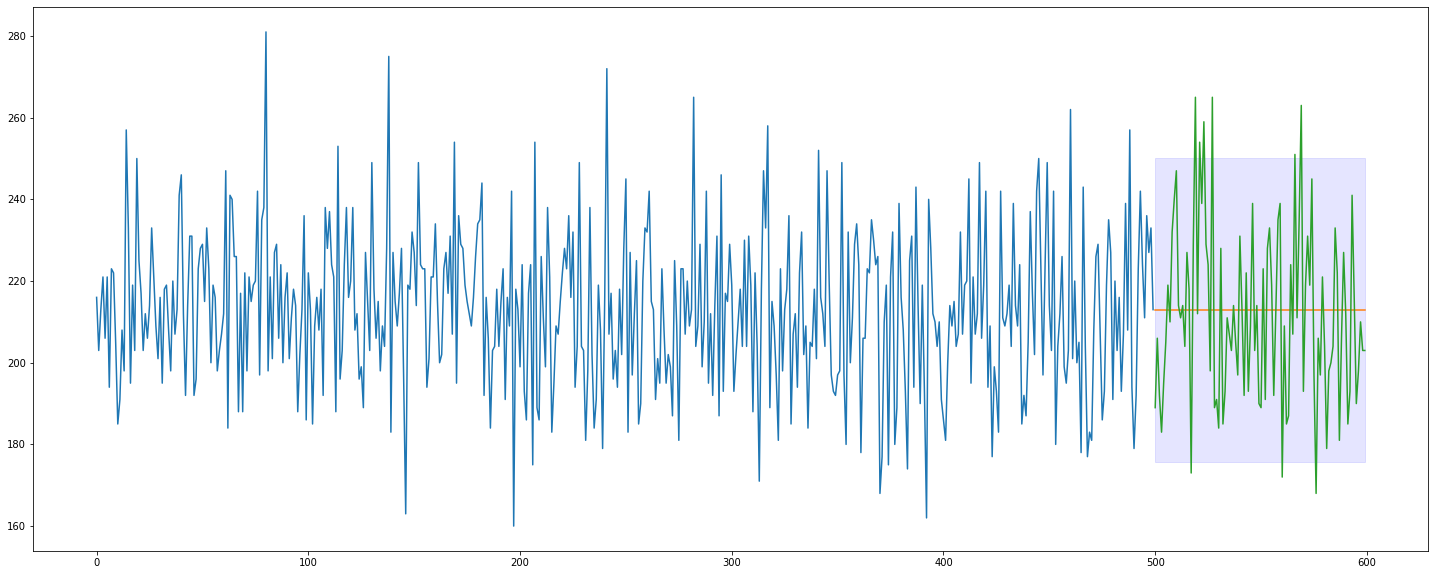

In [34]:
arima2 = ARIMA(
    df_pts_train['PTS'],
    order=(0,0,0)
).fit()
forecasted = arima2.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|exog|order     |seasonal_order|trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---      |:---          |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(0, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |**21.366**|**17.278**|
|None|(0, 1, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.371|17.290|
|None|(0, 2, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |1161.231|1008.809|
|None|(0, 3, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |60722.469|45650.730|

The parameter $d$ has a high impact on both RMSE and MAE. The higher the values of $d$, higher the RMSE and MAE. The confidence interval becomes wider when increasing the value of $d$.

RMSE: 21.183192938862497
 MAE: 17.013895178228378


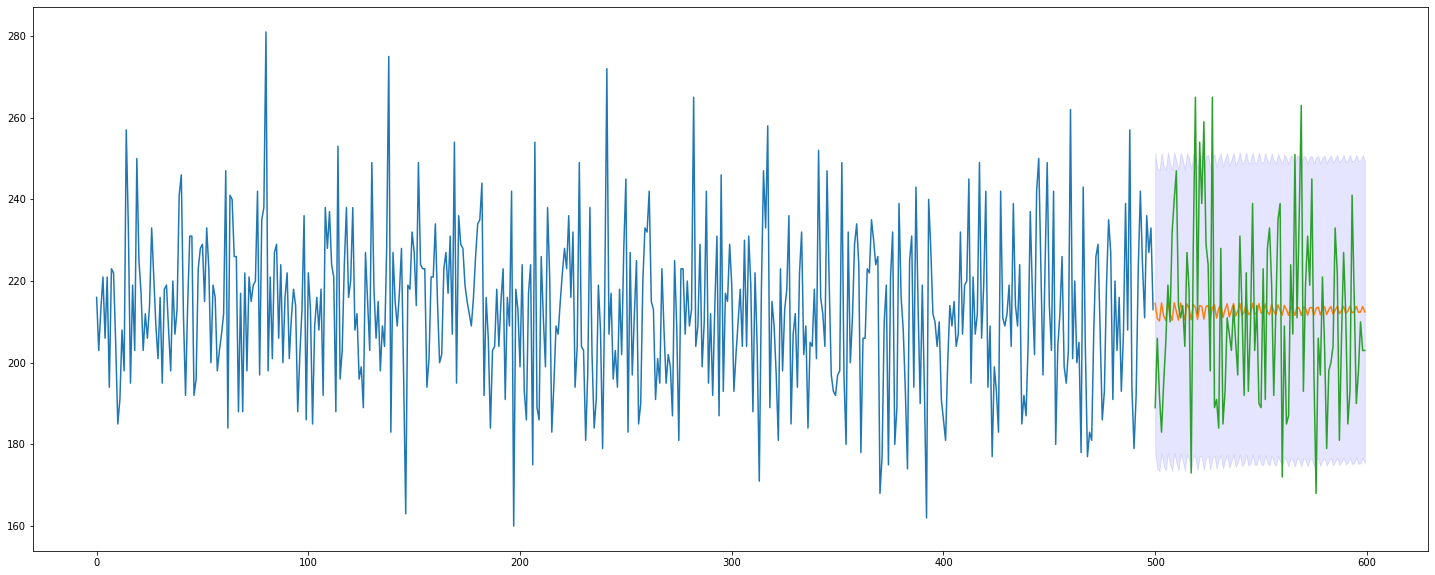

In [35]:
arima2 = ARIMA(
    df_pts_train['PTS'],
    order=(3, 0, 4),
).fit()
forecasted = arima2.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)

print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|exog|order      |seasonal_order|trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---       |:---          |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(30, 0, 0) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.259|17.283|
|None|(30, 0, 1) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.497|17.457|
|None|(30, 0, 2) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.465|17.430|
|None|(30, 0, 3) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.362|17.347|
|None|(30, 0, 4) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.369|17.341|
|None|(30, 0, 5) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.367|17.328|
|None|(30, 0, 5) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.367|17.328|
|None|(30, 0, 8) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.488|17.420|
|None|(30, 1, 8) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.458|17.341|
|None|(30, 0, 10)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.509|17.440|
|None|(30, 1, 10)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.505|17.351|
|None|(30, 0, 15)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.447|17.404|
|None|(30, 1, 15)|(0, 0, 0, 0)  |None |True                |True                 |False            |21.447|17.323|
|None|(2, 0, 7)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.195|17.040|
|None|(2, 0, 10) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.175|17.000|
|None|(2, 0, 11) |(0, 0, 0, 0)  |None |True                |True                 |False            |21.213|17.063|
|None|(3, 0, 4)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.183|17.013|
|None|(3, 0, 8)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.200|17.059|
|None|(4, 0, 3)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.180|17.022|
|None|(4, 0, 4)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.226|17.079|
|None|(4, 0, 8)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.059|16.872|
|None|(5, 0, 7)  |(0, 0, 0, 0)  |None |True                |True                 |False            |21.059|16.898|
|None|(7, 0, 15)  |(0, 0, 0, 0)  |None |True                |True                 |False           |21.013|17.145|
|None|(11, 0, 11)  |(0, 0, 0, 0)  |None |True                |True                 |False          |**20.922**|16.922|
|None|(14, 0, 11)  |(0, 0, 0, 0)  |None |True                |True                 |False          |20.956|**16.741**|


There is no improvement compared to Exponential smoothing.

RMSE: 21.68944000469648
 MAE: 17.439283259809052


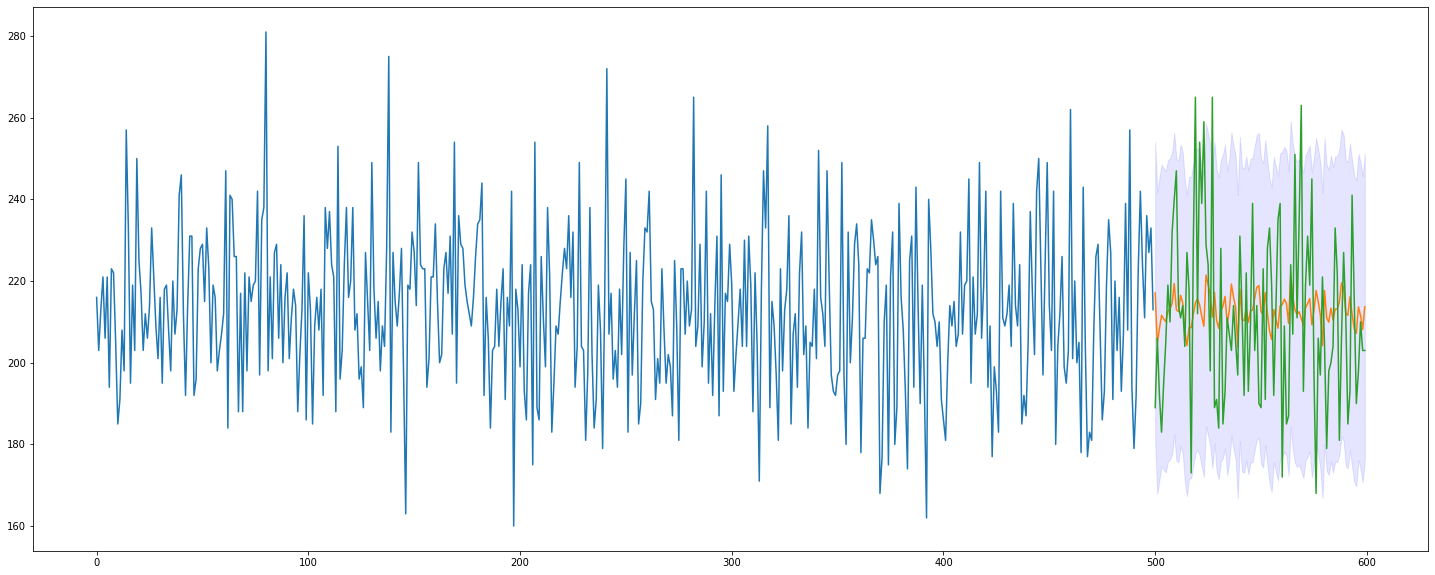

In [36]:
arima2 = ARIMA(
    df_pts_train['PTS'],
    seasonal_order=(8, 1, 3, 8),
).fit()
forecasted = arima2.get_forecast(df_pts_test.shape[0])
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, df_pts_test, squared=False)
mae = mean_absolute_error(mean, df_pts_test)

print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(df_pts_train.shape[0])), df_pts_train)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), mean)
plt.fill_between(
    list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])),
    conf_int['lower PTS'], conf_int['upper PTS'], color='b', alpha=0.1
)
plt.plot(list(range(df_pts_train.shape[0], df_pts_train.shape[0] + df_pts_test.shape[0])), df_pts_test)
plt.show()

|exog|order      |seasonal_order |trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---       |:---           |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(0, 0, 0)  |(4, 0, 3, 2)   |None |True                |True                 |False            |21.252|17.169|
|None|(0, 0, 0)  |(6, 0, 3, 2)   |None |True                |True                 |False            |21.270|17.179|
|None|(0, 0, 0)  |(6, 1, 3, 2)   |None |True                |True                 |False            |21.368|**16.995**|
|None|(0, 0, 0)  |(8, 1, 3, 2)   |None |True                |True                 |False            |**21.336**|17.052|
|None|(0, 0, 0)  |(12, 1, 5, 2)  |None |True                |True                 |False            |22.194|18.095|
|None|(0, 0, 0)  |(11, 0, 11, 2) |None |True                |True                 |False            |21.816|17.756|
|None|(0, 0, 0)  |(11, 0, 11, 3) |None |True                |True                 |False            |21.617|17.758|
|None|(0, 0, 0)  |(11, 0, 11, 4) |None |True                |True                 |False            |21.438|17.298|
|None|(0, 0, 0)  |(11, 0, 11, 5) |None |True                |True                 |False            |22.203|17.918|

The change in the error isn't very big. The higher the value of $s$ affect the periodicity of the signal.

## **4. Facebook Prophet**

In [37]:
pip install fbprophet

Note: you may need to restart the kernel to use updated packages.


In [38]:
from fbprophet import Prophet

In [39]:
datetimes = pd.date_range(
    start='15/6/2018', 
    periods=df_pts_train.shape[0] + df_pts_test.shape[0], 
    freq='8h'
).to_series()

datetimes_new_index = pd.DataFrame(datetimes).set_index([pd.Index(list(range(df_pts_test.shape[0] + df_pts_train.shape[0])))])
datetimes_new_index_train = datetimes_new_index[:df_pts_train.shape[0]]
datetimes_new_index_test = datetimes_new_index[df_pts_train.shape[0]:df_pts_train.shape[0] + df_pts_test.shape[0]].reset_index(drop=True)

df_pts_train_tmp = df_pts_train.reset_index(drop=True)
# df_pts_test_tmp = df_pts_test.reset_index(drop=True)

df_pts_train_prophet = pd.concat((df_pts_train_tmp, datetimes_new_index_train), axis=1)
# df_pts_test_prophet = pd.concat((df_pts_test_tmp, datetimes_new_index_test), axis=1)

df_pts_train_prophet.rename(columns={'PTS':'y', 0:'ds'}, inplace=True)
# df_pts_test_prophet.rename(columns={'PTS':'y', 0:'ds'}, inplace=True)

display(df_pts_train_prophet.head())
# display(df_pts_test_prophet.head())

print(df_pts_train_prophet.shape)

,y,ds
0,216,2018-06-15 00:00:00
1,203,2018-06-15 08:00:00
2,213,2018-06-15 16:00:00
3,221,2018-06-16 00:00:00
4,206,2018-06-16 08:00:00


(500, 2)


In [40]:
model = Prophet()
model.fit(df_pts_train_prophet)
future = model.make_future_dataframe(periods=100)
preds = model.predict(future)

preds.head()

Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1104.41    4.7637e-05       75.5132   6.081e-07       0.001      134  LS failed, Hessian reset 
      99       1104.42    2.6694e-07       80.3625      0.3102           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1104.42   9.03559e-06       81.1227   1.324e-07       0.001      236  LS failed, Hessian reset 
     163       1104.42   1.86136e-07       78.8544      0.3816           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-15 00:00:00,215.715781,192.081713,239.426296,215.715781,215.715781,0.014907,0.014907,0.014907,2.224934,2.224934,2.224934,-2.210027,-2.210027,-2.210027,0.0,0.0,0.0,215.730688
1,2018-06-15 08:00:00,215.705311,190.772356,240.790693,215.705311,215.705311,0.099785,0.099785,0.099785,0.238336,0.238336,0.238336,-0.138551,-0.138551,-0.138551,0.0,0.0,0.0,215.805096
2,2018-06-15 16:00:00,215.694840,189.437551,239.182241,215.694840,215.694840,-1.459187,-1.459187,-1.459187,-3.162260,-3.162260,-3.162260,1.703072,1.703072,1.703072,0.0,0.0,0.0,214.235653
3,2018-06-16 00:00:00,215.684370,195.707865,245.356001,215.684370,215.684370,4.260649,4.260649,4.260649,2.224934,2.224934,2.224934,2.035715,2.035715,2.035715,0.0,0.0,0.0,219.945019
4,2018-06-16 08:00:00,215.673900,191.116723,240.950108,215.673900,215.673900,0.874665,0.874665,0.874665,0.238336,0.238336,0.238336,0.636329,0.636329,0.636329,0.0,0.0,0.0,216.548565


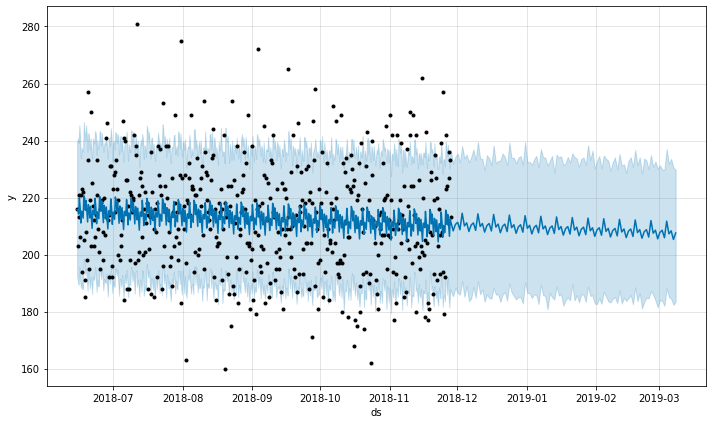

In [41]:
fig1 = model.plot(preds)

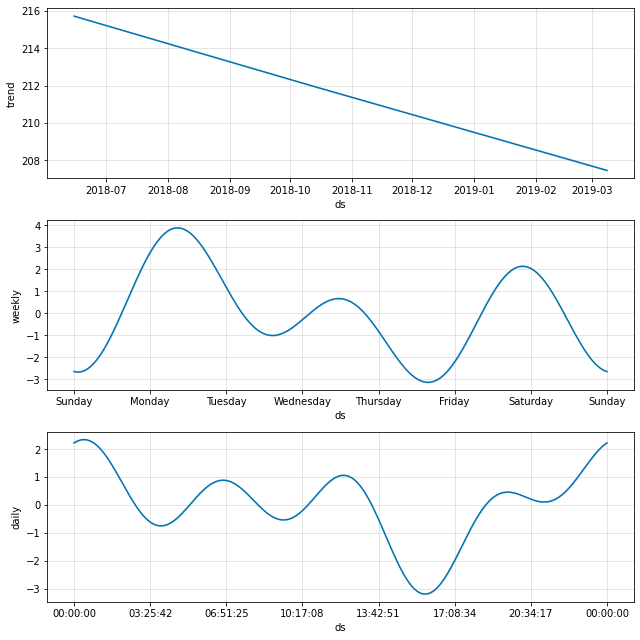

In [42]:
fig2 = model.plot_components(preds)

In [43]:
y_hat = preds['yhat'][-100:]
rmse = mean_squared_error(y_hat, df_pts_test, squared=False)
mae = mean_absolute_error(y_hat, df_pts_test)

print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

RMSE: 21.35686316439568
 MAE: 16.70148911815699


In [44]:
model = Prophet(
    yearly_seasonality=8,
    weekly_seasonality=3,
    daily_seasonality=5,
)
model.fit(df_pts_train_prophet)
future = model.make_future_dataframe(periods=100)
preds = model.predict(future)

y_hat = preds['yhat'][-100:]
rmse = mean_squared_error(y_hat, df_pts_test, squared=False)
mae = mean_absolute_error(y_hat, df_pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       1107.84   1.61568e-08       99.0205      0.3458      0.7797       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
RMSE: 20.734423767988357
 MAE: 16.83965763871138


|yearly_seasonality |weekly_seasonality |daily_seasonality |RMSE  |MAE   |
|:---               |:---               |:---              |:---  |:---  |
|0                  |auto               |auto              |21.357|16.701|
|0                  |3                  |1                 |21.358|16.702|
|0                  |4                  |0                 |21.423|16.683|
|0                  |4                  |1                 |21.364|**16.655**|
|6                  |0                  |0                 |21.103|17.084|
|6                  |1                  |0                 |21.075|17.029|
|6                  |4                  |0                 |21.059|16.802|
|8                  |0                  |5                 |20.982|17.168|
|8                  |0                  |6                 |20.922|17.115|
|8                  |0                  |7                 |20.882|17.081|
|8                  |1                  |0                 |20.781|16.959|
|8                  |3                  |5                 |**20.734**|16.839|

The seasonality_mode hyperparameter is set to 'additive' because 'multiplicative' consistently performed worse. This managed to reduce the error but not by much. Compared to the other algorithms this one has the best performance so far.

## **5. RandomForestRegressor** 

In [45]:
df_rtg_train = df_rtg[:-100]
df_rtg_test = df_rtg[-100:]

df_whole_train = pd.concat((df_rtg_train, df_pts_train), axis=1)
df_whole_test = pd.concat((df_rtg_test, df_pts_test), axis=1)

df_whole_train.head(15)

,OFF_RATING_HOME,OFF_RATING_AWAY,DEF_RATING_HOME,DEF_RATING_AWAY,TEAM_ABBREVIATION_HOME,TEAM_ABBREVIATION_AWAY,NEXT_HOME,NEXT_AWAY,PTS
630,115.0,91.7,91.7,115.0,NOP,ORL,HOU,MIL,216
631,112.6,90.1,90.1,112.6,HOU,MIL,DET,ATL,203
632,120.0,95.7,95.7,120.0,DET,ATL,GSW,OKC,213
633,116.5,95.8,95.8,116.5,GSW,OKC,SAC,IND,221
634,105.4,114.0,114.0,105.4,SAC,IND,CLE,PHX,206
635,116.4,103.4,103.4,116.4,CLE,PHX,MIA,DAL,221
636,106.7,103.4,103.4,106.7,MIA,DAL,NYK,WAS,194
637,113.8,114.0,114.0,113.8,NYK,WAS,SAS,DEN,223
638,119.2,97.7,97.7,119.2,SAS,DEN,LAC,MIN,222
639,106.8,108.3,108.3,106.8,LAC,MIN,PHI,POR,205


In [46]:
def calc_mean(df, mask):
    if not mask.any():
        return np.array([0 for i in range((df.shape[1] - 5))])

    values = df[mask].mean().tolist()[:-1]
    return np.array(values)


home, away = 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY'
all_rows = []
for i in range(1 + df_whole_train.index.values[0], df_whole_train.shape[0] + df_whole_train.index.values[0]):    
    rows_before = df_whole_train.loc[:i-1]
    row_curr = df_whole_train.loc[i]
    
    mask1 = (rows_before[home] == row_curr[home])
    mask2 = (rows_before[away] == row_curr[away])
    
    mean1 = calc_mean(rows_before, mask1)
    mean2 = calc_mean(rows_before, mask2)
    
    mean_total = np.concatenate((mean1[[0, 2]], mean2[[1, 3]]), axis=0).tolist()
    
    all_rows.append(mean_total)
        

In [47]:
all_rows[-2:]

[[110.58823529411765,
  103.51764705882353,
  100.20714285714288,
  117.02142857142856],
 [106.79374999999999,
  105.79374999999999,
  100.63846153846154,
  115.33846153846154]]

In [48]:
all_rows2 = []
for i in range(df_whole_test.index.values[0], df_whole_test.shape[0] + df_whole_test.index.values[0]):
    rows_before = df_whole_train
    row_curr = df_whole_test.loc[i]
    
    mask1 = (rows_before[home] == row_curr[home])
    mask2 = (rows_before[away] == row_curr[away])
    
    mean1 = calc_mean(rows_before, mask1)
    mean2 = calc_mean(rows_before, mask2)
    
    mean_total = np.concatenate((mean1[[0, 2]], mean2[[1, 3]]), axis=0).tolist()
    
    all_rows2.append(mean_total)

In [49]:
all_rows2[-2:]

[[116.60769230769228,
  95.42307692307693,
  100.54666666666667,
  113.79333333333334],
 [112.425, 107.4125, 102.69999999999999, 104.8125]]

In [50]:
columns = ['AVG_OFF_RTG_HOME', 'AVG_DEF_RTG_HOME', 'AVG_OFF_RTG_AWAY', 'AVG_DEF_RTG_AWAY']
df_train_forest = pd.DataFrame(
    data=all_rows,
    index=list(range(len(all_rows))),
    columns=columns
)
row_df = pd.DataFrame([[0 for i in range(len(columns))]], columns=columns)
df_train_forest = pd.concat([row_df, df_train_forest], ignore_index=True)

In [51]:
df_train_forest.head()

,AVG_OFF_RTG_HOME,AVG_DEF_RTG_HOME,AVG_OFF_RTG_AWAY,AVG_DEF_RTG_AWAY
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [52]:
df_test_forest = pd.DataFrame(
    data=all_rows2,
    index=list(range(len(all_rows2))),
    columns=columns
)

df_test_forest.head()

,AVG_OFF_RTG_HOME,AVG_DEF_RTG_HOME,AVG_OFF_RTG_AWAY,AVG_DEF_RTG_AWAY
0,107.978571,107.007143,102.107692,110.500000
1,107.664706,106.705882,102.206250,111.193750
2,113.094444,102.238889,102.647059,109.517647
3,106.580000,103.453333,111.384211,108.184211
4,110.050000,107.693750,105.562500,101.137500


In [53]:
y_train = df_whole_train['PTS'].reset_index(drop=True)
y_test = df_whole_test['PTS'].reset_index(drop=True)

y_test.head()

0    189
1    206
2    192
3    183
4    195
Name: PTS, dtype: int64

In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300, max_depth=2, max_features='log2', criterion='absolute_error')
model.fit(df_train_forest, y_train)
y_hat_test = model.predict(df_test_forest)

rmse = mean_squared_error(y_test, y_hat_test, squared=False)
mae = mean_absolute_error(y_test, y_hat_test)

print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

RMSE: 21.258689554705235
 MAE: 17.037283333333335


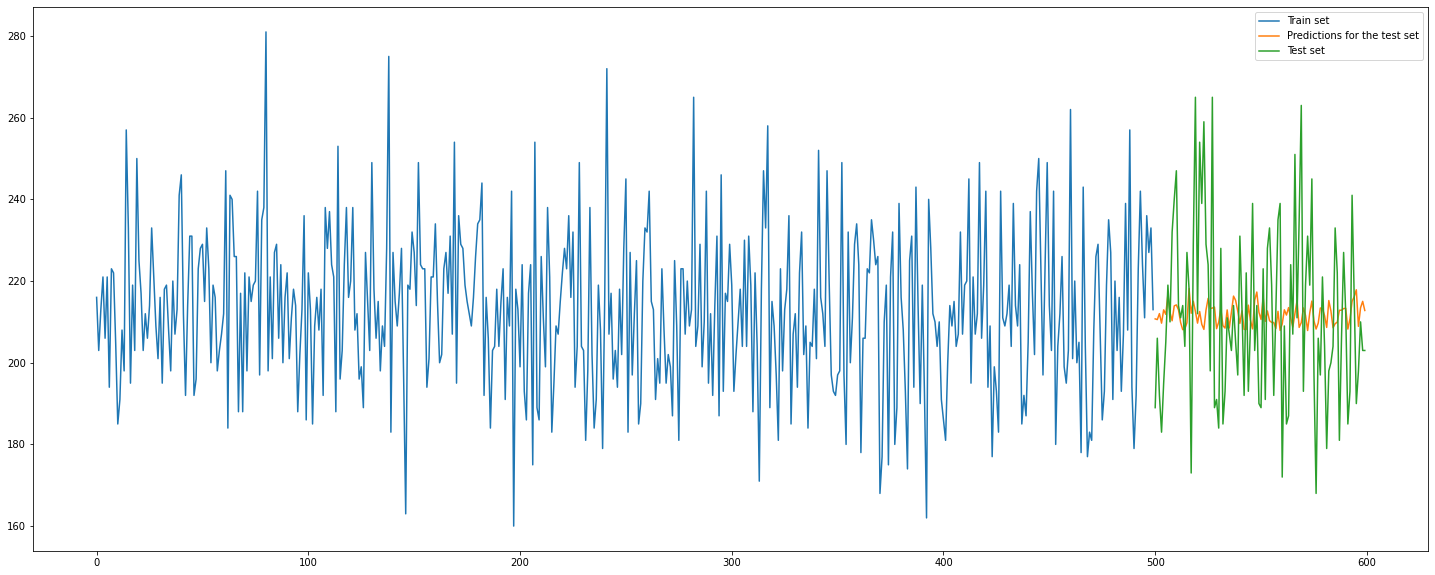

In [55]:
len_train = len(df_train_forest)
plt.figure(figsize=(25, 10))
plt.plot(list(range(len_train)), y_train, label='Train set')
plt.plot(list(range(len_train, len_train + len(df_test_forest))), y_hat_test, label='Predictions for the test set')
plt.plot(list(range(len_train, len_train + len(df_test_forest))), y_test, label='Test set')
plt.legend()
plt.show()

The results are a bit worse than the ARIMA and exponential smooting methods, but this method still works well. All of the results are pretty close though.

In [56]:
df_ast = df_merged[['AST_HOME', 'AST_AWAY', 'BLK_HOME', 'BLK_AWAY', 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY', 'NEXT_HOME', 'NEXT_AWAY']][-600:]

df_ast_train = df_ast[:-100]
df_ast_test = df_ast[-100:]

df_whole_train2 = pd.concat((df_ast_train, df_pts_train), axis=1)
df_whole_test2 = pd.concat((df_ast_test, df_pts_test), axis=1)

df_whole_train2.head()

,AST_HOME,AST_AWAY,BLK_HOME,BLK_AWAY,TEAM_ABBREVIATION_HOME,TEAM_ABBREVIATION_AWAY,NEXT_HOME,NEXT_AWAY,PTS
630,28,18,5,5,NOP,ORL,HOU,MIL,216
631,25,26,12,8,HOU,MIL,DET,ATL,203
632,27,22,0,4,DET,ATL,GSW,OKC,213
633,35,23,8,6,GSW,OKC,SAC,IND,221
634,28,22,5,3,SAC,IND,CLE,PHX,206


In [57]:
all_rows = []
for i in range(1 + df_whole_train2.index.values[0], df_whole_train2.shape[0] + df_whole_train2.index.values[0]):    
    rows_before = df_whole_train2.loc[:i-1]
    row_curr = df_whole_train2.loc[i]
    
    mask1 = (rows_before[home] == row_curr[home])
    mask2 = (rows_before[away] == row_curr[away])
    
    mean1 = calc_mean(rows_before, mask1)
    mean2 = calc_mean(rows_before, mask2)
    
    mean_total = np.concatenate((mean1[[0, 2]], mean2[[1, 3]]), axis=0).tolist()
    
    all_rows.append(mean_total)
    
all_rows2 = []
for i in range(df_whole_test2.index.values[0], df_whole_test2.shape[0] + df_whole_test2.index.values[0]):
    rows_before = df_whole_train2
    row_curr = df_whole_test2.loc[i]
    
    mask1 = (rows_before[home] == row_curr[home])
    mask2 = (rows_before[away] == row_curr[away])
    
    mean1 = calc_mean(rows_before, mask1)
    mean2 = calc_mean(rows_before, mask2)
    
    mean_total = np.concatenate((mean1[[0, 2]], mean2[[1, 3]]), axis=0).tolist()
    
    all_rows2.append(mean_total)
    
columns2 = ['AVG_AST_HOME', 'AVG_BLK_HOME', 'AVG_AST_AWAY', 'AVG_BLK_AWAY']
df_train_forest2 = pd.DataFrame(
    data=all_rows,
    index=list(range(len(all_rows))),
    columns=columns2
)
row_df = pd.DataFrame([[0 for i in range(len(columns2))]], columns=columns2)
df_train_forest2 = pd.concat([row_df, df_train_forest2], ignore_index=True)

df_test_forest2 = pd.DataFrame(
    data=all_rows2,
    index=list(range(len(all_rows2))),
    columns=columns2
)

In [58]:
df_train_forest2.head()

,AVG_AST_HOME,AVG_BLK_HOME,AVG_AST_AWAY,AVG_BLK_AWAY
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [59]:
df_test_forest2.head()

,AVG_AST_HOME,AVG_BLK_HOME,AVG_AST_AWAY,AVG_BLK_AWAY
0,22.071429,4.071429,20.384615,3.615385
1,23.176471,5.941176,22.875000,4.250000
2,20.888889,6.611111,21.941176,5.411765
3,19.000000,4.400000,24.157895,4.052632
4,20.500000,4.312500,21.937500,5.312500


In [72]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='absolute_error')
model.fit(df_train_forest2, y_train)
y_hat_test = model.predict(df_test_forest2)

rmse = mean_squared_error(y_test, y_hat_test, squared=False)
mae = mean_absolute_error(y_test, y_hat_test)

print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

RMSE: 20.50077586946406
 MAE: 16.49465


I've managed to improve on the previous results, but not by a lot.

## **6. Generated signal** 

In [61]:
from scipy import signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 200 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(134*np.pi)
trend1 = np.linspace(0, 100, 100)/(104*np.pi)
trend2 = np.linspace(0, 300, 300)/(-122*np.pi)
trend3 = np.linspace(0, 200, 200)/(111*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

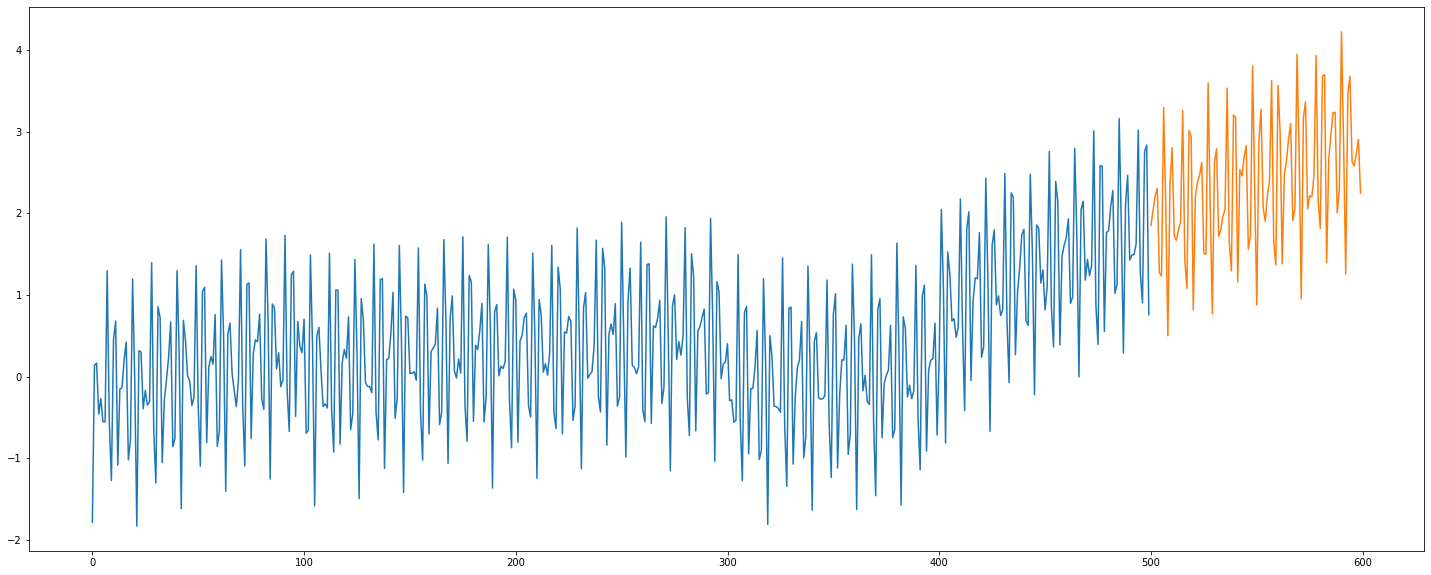

In [62]:
plt.figure(figsize=(25, 10))
plt.plot(list(range(len(pts_train))), pts_train, label='Train set')
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), pts_test, label='Test set')
plt.show()

The signal consists of 2 sawtooths signals, 4 trend components and normal noise. The signal is almost periodical with a period around 22. 

At first the trend is slightly rising up to the 100th observation after which there's a slight drop.
The second trend is also slightly rising with a slight drop around the 300th observation.
The third trend is neither rising nor falling, while the fourth trend is rising and starts around the 400th observation.

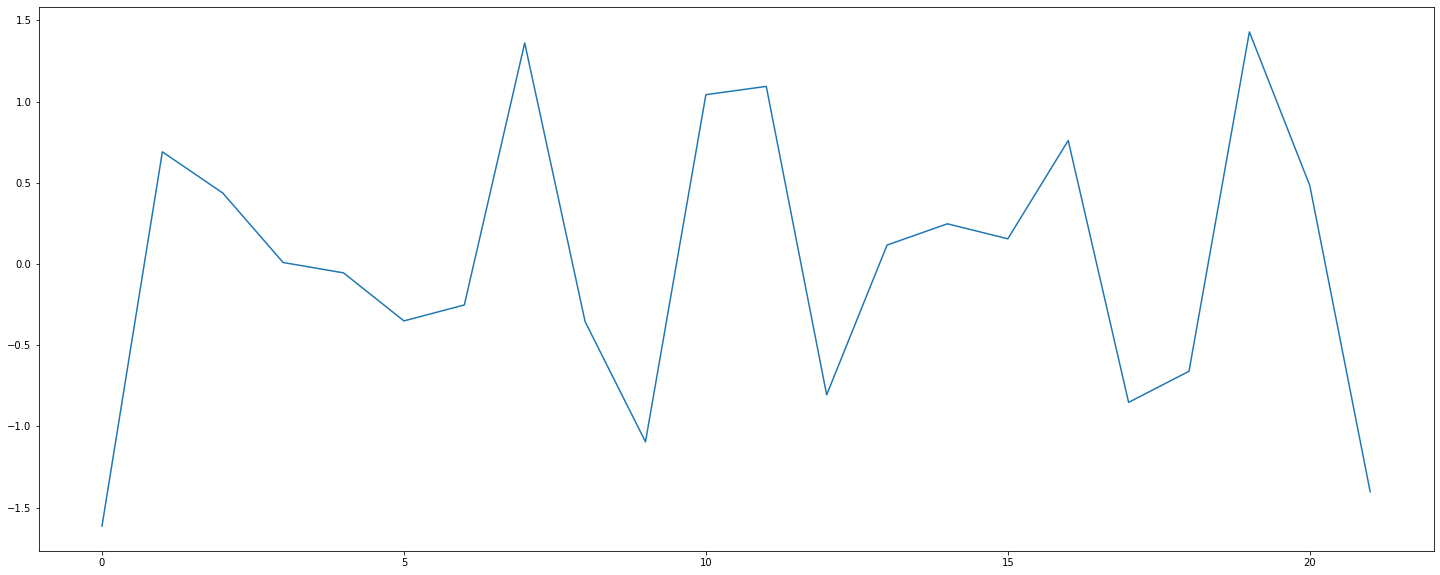

In [93]:
plt.figure(figsize=(25, 10))
plt.plot(list(range(len(pts_train[42:64]))), pts_train[42:64])
plt.show()

RMSE: 0.38625985858416845
 MAE: 0.3146070349259756


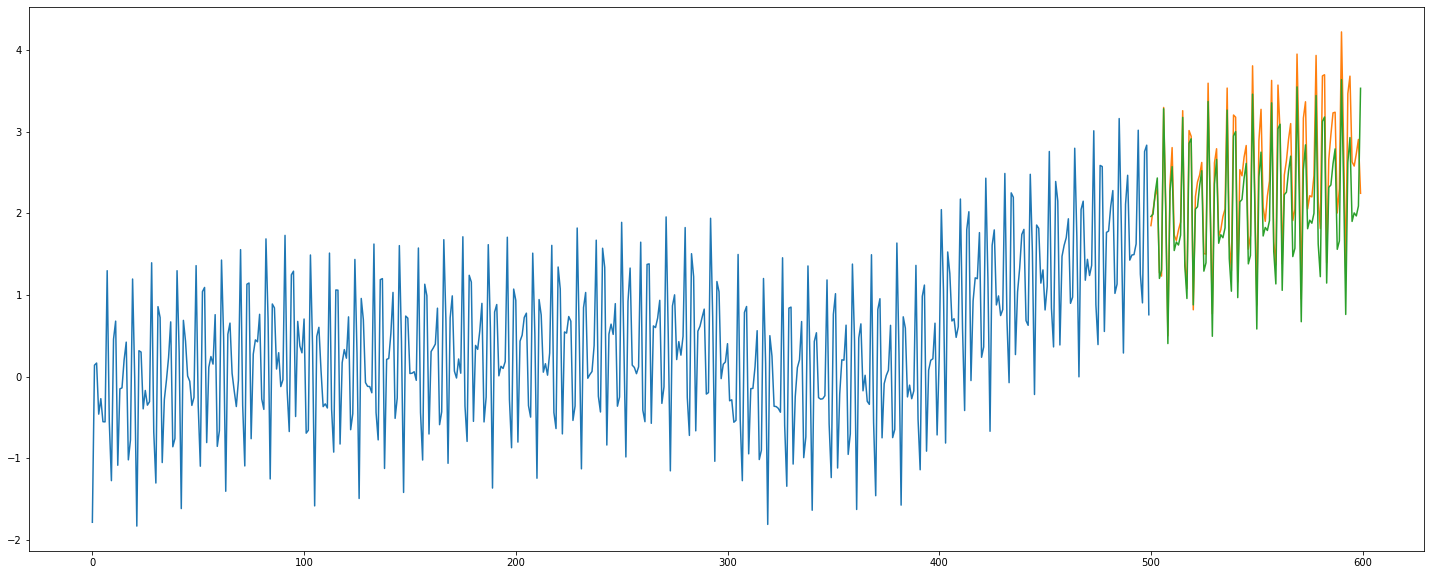

In [63]:
exp_smooth = ExponentialSmoothing(
    pts_train,  
    seasonal_periods=21,
    trend='add',
    seasonal='add', 
    damped=False,
    initialization_method='estimated'
).fit()
forecasted = exp_smooth.forecast(steps=len(pts_test))

rmse = mean_squared_error(forecasted, pts_test, squared=False)
mae = mean_absolute_error(forecasted, pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(len(pts_train))), pts_train)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), pts_test)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), forecasted)
plt.show()

|seasonal_periods|trend|seasonal|use_boxcox|damped|initialization_method|smoothing_level|smoothing_trend|smoothing_seasonal|RMSE  |MAE   |
|:---            |:--- |:---    |:---      |      |:---                 |:---           |:---           |:---              |:---  |:---  |
|2 |add  |add     |False      |True |estimated   |               |               |                  |0.931|0.762|
|3 |add  |add     |False     |True |estimated   |               |               |                  |0.738|0.610|
|4 |add  |add     |False     |True |estimated   |               |               |                  |1.129|0.934|
|5 |add  |add     |False     |True |estimated   |               |               |                  |0.931|0.762|
|6 |add  |add     |False     |True |estimated   |               |               |                  |0.738|0.609|
|21 |add  |add     |False     |True |estimated   |               |               |                  |0.487|0.407|
|21 |add  |add     |False     |False |estimated   |               |               |                  |**0.419**|**0.346**|


RMSE: 0.34124562769378247
 MAE: 0.2629437018733372


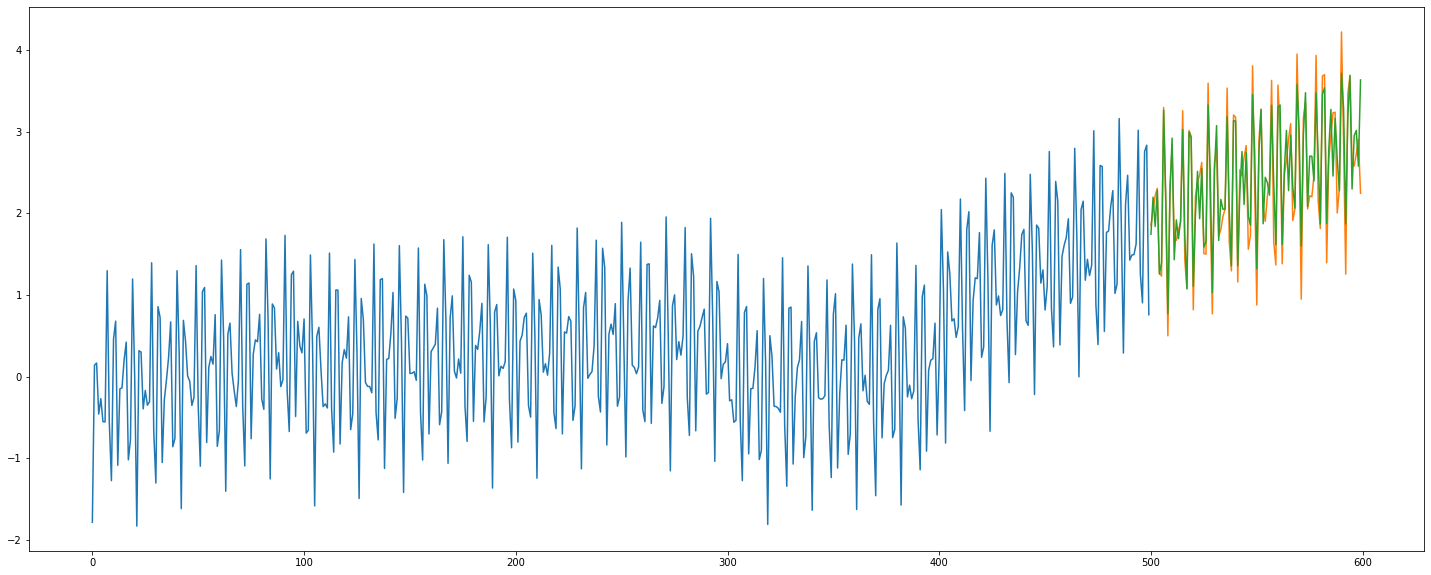

In [64]:
arima2 = ARIMA(
    pts_train,
    order=(1,0,1),
    seasonal_order=(3, 2, 1, 3)
).fit()
forecasted = arima2.get_forecast(len(pts_test))
mean, conf_int = forecasted.predicted_mean, forecasted.conf_int(alpha=0.05)

rmse = mean_squared_error(mean, pts_test, squared=False)
mae = mean_absolute_error(mean, pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(len(pts_train))), pts_train)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), pts_test)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), mean)
plt.show()

|exog|order      |seasonal_order|trend|enforce_stationarity|enforce_invertibility|concentrate_scale|RMSE  |MAE   |
|:---|:---       |:---          |:--- |:---                |:---                 |:---             |:---  |:---  |
|None|(0, 0, 0) |(0, 0, 0, 0)  |None |True                |True            |False            |2.151|1.985|
|None|(4, 1, 4) |(0, 0, 0, 0)  |None |True                |True            |False            |0.615|0.483|
|None|(4, 2, 3) |(0, 0, 0, 0)  |None |True                |True            |False            |0.573|0.489|
|None|(4, 2, 4) |(0, 0, 0, 0)  |None |True                |True            |False            |0.460|0.370|
|None|(0, 0, 0) |(2, 2, 1, 3)  |None |True                |True            |False            |0.627|0.492|
|None|(0, 0, 0) |(2, 2, 2, 3)  |None |True                |True            |False            |0.437|0.341|
|None|(0, 0, 0) |(2, 2, 3, 3)  |None |True                |True            |False            |0.410|0.323|
|None|(0, 0, 0) |(2, 2, 4, 3)  |None |True                |True            |False            |0.407|0.324|
|None|(0, 0, 0) |(3, 2, 1, 3)  |None |True                |True            |False            |0.374|0.281|
|None|(1, 0, 1) |(3, 2, 1, 3)  |None |True                |True            |False            |**0.315**|**0.229**|


In [65]:
datetimes = pd.date_range(
    start='15/6/2018', 
    periods=len(pts_train) + len(pts_test), 
    freq='8h'
).to_series()

datetimes_new_index = pd.DataFrame(datetimes).set_index([pd.Index(list(range(len(pts_train) + len(pts_test))))])
datetimes_new_index_train = datetimes_new_index[:len(pts_train)]
datetimes_new_index_test = datetimes_new_index[len(pts_train):len(pts_train)+ len(pts_test)].reset_index(drop=True)

df_pts_train_tmp = df_pts_train.reset_index(drop=True)

df_pts_train_prophet2 = pd.concat((pd.Series(pts_train, name='y'), datetimes_new_index_train), axis=1)

df_pts_train_prophet2.rename(columns={0:'ds'}, inplace=True)

display(df_pts_train_prophet2.head())

print(df_pts_train_prophet2.shape)

,y,ds
0,-1.782102,2018-06-15 00:00:00
1,0.141770,2018-06-15 08:00:00
2,0.167849,2018-06-15 16:00:00
3,-0.457765,2018-06-16 00:00:00
4,-0.268140,2018-06-16 08:00:00


(500, 2)


In [66]:
model = Prophet()
model.fit(df_pts_train_prophet2)
future = model.make_future_dataframe(periods=100)
preds = model.predict(future)

preds.head()

Initial log joint probability = -46.0159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.111   0.000161134       95.9338           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       423.234    0.00155177       79.5331   2.003e-05       0.001      175  LS failed, Hessian reset 
     167       423.311   7.17555e-05       73.0827   8.251e-07       0.001      300  LS failed, Hessian reset 
     199       423.317   8.53583e-07       80.6841      0.8128      0.8128      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       423.317   8.07102e-09        73.324      0.1598           1      398   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-15 00:00:00,-0.904893,-1.438236,0.560676,-0.904893,-0.904893,0.475128,0.475128,0.475128,0.490307,0.490307,0.490307,-0.015179,-0.015179,-0.015179,0.0,0.0,0.0,-0.429765
1,2018-06-15 08:00:00,-0.903732,-0.872177,1.063572,-0.903732,-0.903732,0.978599,0.978599,0.978599,0.993507,0.993507,0.993507,-0.014909,-0.014909,-0.014909,0.0,0.0,0.0,0.074867
2,2018-06-15 16:00:00,-0.902571,-0.815898,1.222888,-0.902571,-0.902571,1.122740,1.122740,1.122740,1.142062,1.142062,1.142062,-0.019322,-0.019322,-0.019322,0.0,0.0,0.0,0.220170
3,2018-06-16 00:00:00,-0.901410,-1.485409,0.579808,-0.901410,-0.901410,0.465249,0.465249,0.465249,0.490307,0.490307,0.490307,-0.025058,-0.025058,-0.025058,0.0,0.0,0.0,-0.436160
4,2018-06-16 08:00:00,-0.900249,-0.982843,1.099670,-0.900249,-0.900249,0.965803,0.965803,0.965803,0.993507,0.993507,0.993507,-0.027704,-0.027704,-0.027704,0.0,0.0,0.0,0.065555


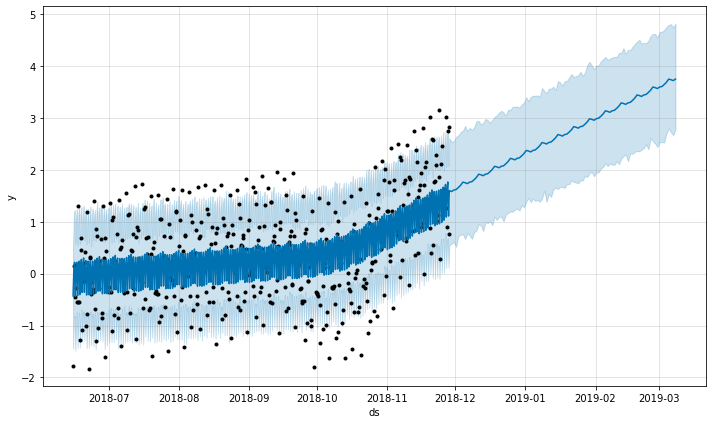

In [67]:
fig1 = model.plot(preds)

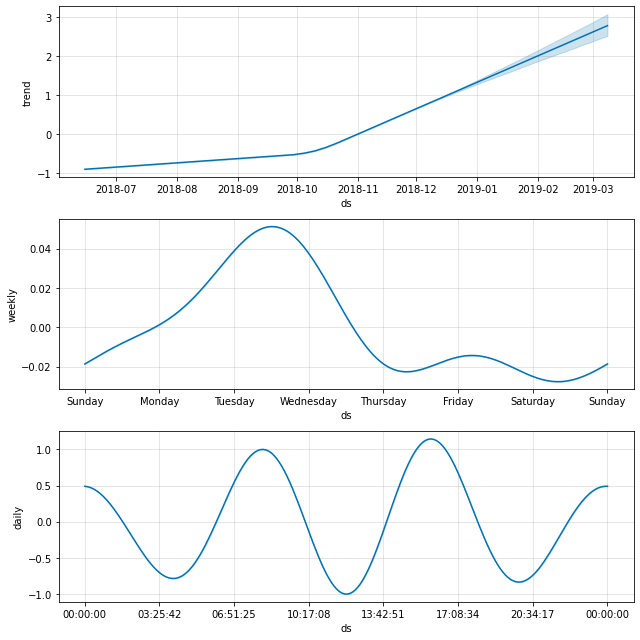

In [68]:
fig2 = model.plot_components(preds)

Initial log joint probability = -46.0159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       439.259   9.07439e-09       100.464      0.4293      0.4293      105   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
RMSE: 0.8562116670239436
 MAE: 0.6913848146066262


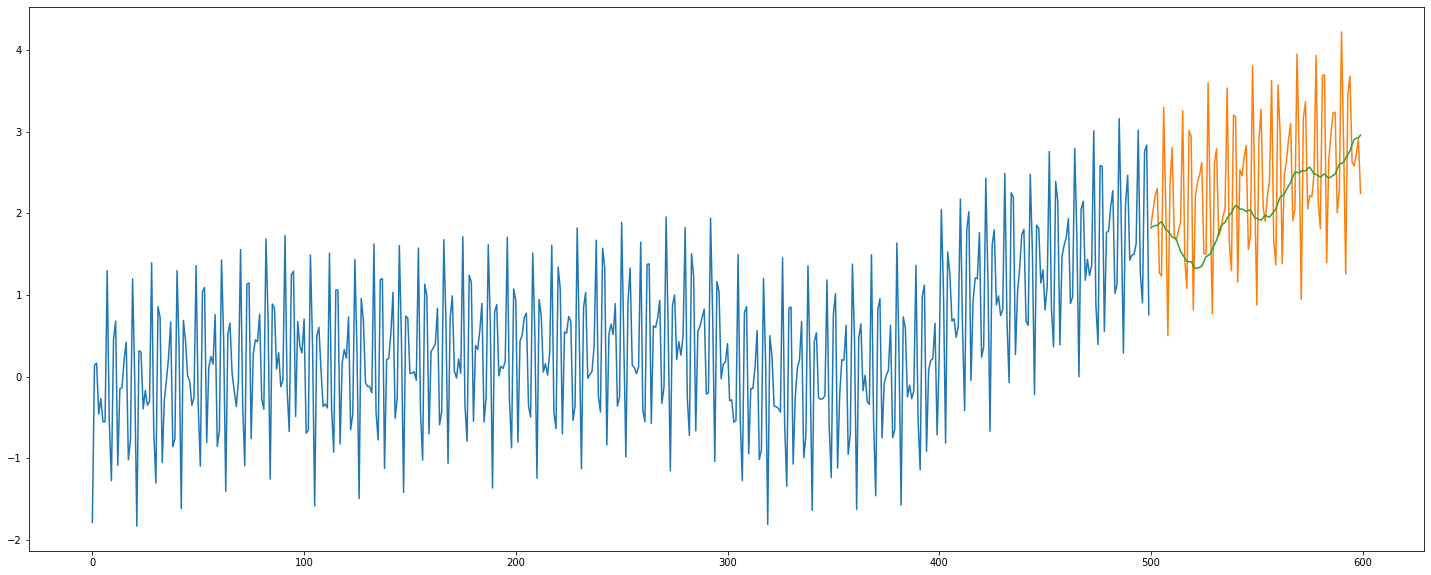

In [69]:
model = Prophet(
    yearly_seasonality=12,
    weekly_seasonality=2,
    daily_seasonality=0,
)
model.fit(df_pts_train_prophet2)
future = model.make_future_dataframe(periods=100)

preds = model.predict(future)

y_hat = preds['yhat'][-100:]
rmse = mean_squared_error(y_hat, pts_test, squared=False)
mae = mean_absolute_error(y_hat, pts_test)
print(f'RMSE: {rmse}')
print(f' MAE: {mae}')

plt.figure(figsize=(25, 10))
plt.plot(list(range(len(pts_train))), pts_train)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), pts_test)
plt.plot(list(range(len(pts_train), len(pts_train) + len(pts_test))), y_hat)
plt.show()

|yearly_seasonality |weekly_seasonality |daily_seasonality |RMSE  |MAE   |
|:---               |:---               |:---              |:---  |:---  |
|0                  |0                  |0                 |0.887 |0.732 |
|0                  |2                  |0                 |0.859 |0.717 |
|2                  |2                  |0                 |1.166 |0.960 |
|12                 |2                  |0                 |**0.824** |**0.677** |
|12                 |5                  |2                 |1.000 |0.833 |
|15                 |5                  |9                 |1.037 |0.879 |
|15                 |5                  |15                |1.056 |0.897 |
|10                 |15                 |0                 |1.056 |0.897 |

ARIMA models the signal very accurately with RMSE 0.315 and MAE 0.229.